In [1]:
################################################
# Numerical Methods for Stochastic             #
# Differential Equations                       #
################################################
#-----------------------------------------------
################################################
# Derivation of explicit formula               #
# for Geometric Asian option                   #
################################################
#-----------------------------------------------

#import libraries
import time
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from random import gauss
from math import exp, sqrt

In [2]:
def Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt):
    ###########################################################################
    #This is a closed form solution for geometric Asian options
    #
    #S0    = Current price of underlying asset
    #sigma = Volatility
    #K     = Strike price
    #r     = Risk-free rate
    #T     = Time to maturity
    #Nt    = Time intervals
    ###########################################################################
    adj_sigma=sigma*sqrt((2*Nt+1)/(6*(Nt+1)))
    rho=0.5*(r-(sigma**2)*0.5+adj_sigma**2)
    d1 = (np.log(S0/K)+(rho+0.5*adj_sigma**2)*T)/(adj_sigma*sqrt(T))
    d2 = (np.log(S0/K)+(rho-0.5*adj_sigma**2)*T)/(adj_sigma*sqrt(T))
    price = exp(-r*T)*(S0*exp(rho*T)*norm.cdf(d1)-K*norm.cdf(d2)) #CDF
    return(price)

In [3]:
S0=100
sigma=0.25
K=100
r=0.02
T=1
Nt=T*365 #number of trading days until maturity

Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt)

5.88676153274918

Call Price: 6.4039
Variance: 87.5889
Standard Deviation: 9.3589
95% Confidence Interval: [5.82386871854111, 6.984009241189302]
Variance Estimator: 87.6766
Root Mean Square Error: 0.2961
Run time: 1.6511


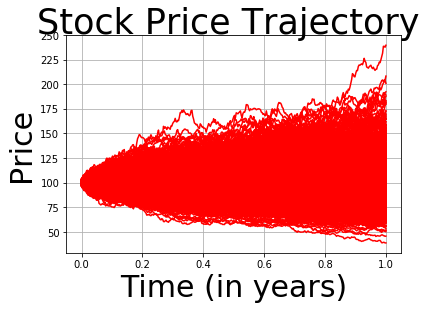

In [4]:
#-----------------------------------------------
################################################
# Simulating the price of the arithmetic Asian #
# option.                                      #
################################################
# (i): Use (plain) Monte Carlo method.         #
################################################
#-----------------------------------------------

S = 100                             #spot price
v = 0.25                            #volatility
r = 0.02                            #interest rate
T = 1                               #maturity
K = 100                             #strike price
N = 365                             #number of discrete time points
delta_t= T / N                      #length of partition interval

M = 1000                            #simulations
price_trajectories = []             #(plain) MC array
payoff_array       = []
discount_factor    = exp(-r * T)

# Tic
t = time.time()

# Calculating payoff vector.
for i in range(0, M):
    stock_path   = []

    S_j = S
    for i in range(0, N):
        xi = np.random.normal(0,1.0)

        S_j *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))

        stock_path.append(S_j)
    
    price_trajectories.append(stock_path)
    Arithmetic_Mean=np.sum(stock_path)/N
    payoff=max(Arithmetic_Mean-K,0)
    payoff_array.append(payoff)

# Computing price
payoff_array = np.array(payoff_array, dtype=float) 
price = np.sum(discount_factor*payoff_array)/M
print(str("Call Price: %.4f") % price)

# Statistics
variance = np.var(discount_factor*payoff_array)
sd = np.std(discount_factor*payoff_array)
# Variance Estimator
varest=sum((price-discount_factor*payoff_array)**2)/(M-1)
# Root Mean Square Error
RMSE=sqrt(varest)/sqrt(M)
# 95% C.I. uses 1.96 z-value
CI = [price - (1.96*sd/sqrt(float(M))),
      price + (1.96*sd/sqrt(float(M)))]

# Toc
elapsed = time.time() - t

#Print
print("Variance: %.4f" % variance)
print("Standard Deviation: %.4f" % sd)
print("95% Confidence Interval:", CI) 
print("Variance Estimator: %.4f" % varest)
print("Root Mean Square Error: %.4f" % RMSE)
print("Run time: %.4f" % elapsed)

# Plot
price_trajectories = np.array(price_trajectories, dtype=float)
times = np.linspace(0, T, N)
plt.figure()
ax1 = plt.subplot2grid((1,1),(0,0))
for sublist in price_trajectories:
    ax1.plot(times,sublist,color = 'red')
ax1.grid(True)
plt.suptitle('Stock Price Trajectory', fontsize=35)
plt.xlabel('Time (in years)', fontsize = 30)
plt.ylabel('Price', fontsize= 30)
plt.show()

Call Price: 6.0198
95% Confidence Interval: [5.168081443543721, 6.871571922792003]
Variance Estimator: 94.4229
Root Mean Square Error: 0.4346
Run time: 1.0689


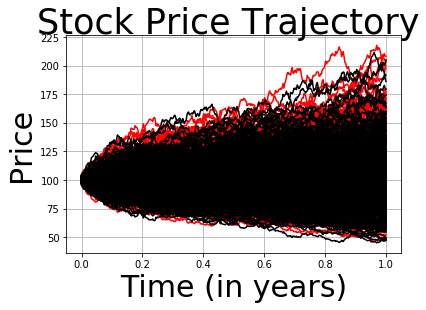

In [5]:
################################################
# (ii): Use Monte Carlo with antithetic        #
# variates.                                    #
################################################
#-----------------------------------------------
M = 1000                            #simulations
price_trajectories   = []           #(Antithetic Variates) MC array
price_trajectories_a = []
payoff_array         = []
payoff_array_a       = []
c                    = []           #Array for discounted payoffs
discount_factor      = exp(-r * T)

# Tic
t = time.time()

# Calculating payoff vector.
for i in range(0, int(M/2)):
    stock_path     = []
    stock_path_a   = []             #array for storing antithetic variate paths

    S_j  =  S
    Sa_j =  S 
    for i in range(0, N):
        xi = np.random.normal(0,1.0)

        S_j  *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))
        # Sa_j stands for Santithetic_j.
        Sa_j *= (exp((r-v**2/2) * delta_t - v *sqrt(delta_t) * xi))

        stock_path.append(S_j)
        stock_path_a.append(Sa_j)
    
    price_trajectories.append(stock_path)
    price_trajectories_a.append(stock_path_a)
    
    Arithmetic_Mean  =np.sum(stock_path  )/N
    Arithmetic_Mean_a=np.sum(stock_path_a)/N
    
    payoff  =max(Arithmetic_Mean  -K,0)
    payoff_a=max(Arithmetic_Mean_a-K,0)
    
    payoff_array.append(payoff)
    payoff_array_a.append(payoff_a)

# Computing price
payoff_array   = np.array(payoff_array  , dtype=float) 
payoff_array_a = np.array(payoff_array_a, dtype=float) 

c=(discount_factor*payoff_array+discount_factor*payoff_array_a)/2

price = (np.sum(c))/(M/2)
print(str("Call Price: %.4f") % price)

# Variance Estimator
varest=sum((price-discount_factor*payoff_array)**2)/(M/2-1)
# Root Mean Square Error
RMSE=sqrt(varest)/sqrt(M/2)
# 95% C.I. uses 1.96 z-value
CI = [price - (1.96*RMSE),
      price + (1.96*RMSE)]

# Toc
elapsed = time.time() - t

#Print
print("95% Confidence Interval:", CI) 
print("Variance Estimator: %.4f" % varest)
print("Root Mean Square Error: %.4f" % RMSE)
print("Run time: %.4f" % elapsed)

# Plot
price_trajectories   = np.array(price_trajectories  , dtype=float)
price_trajectories_a = np.array(price_trajectories_a, dtype=float)
times = np.linspace(0, T, N)
plt.figure()
ax1 = plt.subplot2grid((1,1),(0,0))
for sublist in price_trajectories:
    ax1.plot(times,sublist,color = 'red')
for sublist in price_trajectories_a:
    ax1.plot(times,sublist,color = 'black')
ax1.grid(True)
plt.suptitle('Stock Price Trajectory', fontsize=35)
plt.xlabel('Time (in years)', fontsize = 30)
plt.ylabel('Price', fontsize= 30)
plt.show()

Call Price: 6.5258
95% Confidence Interval: [6.411443215066404, 6.6400908267827194]
Variance Estimator: 200.4038
RMSE: 0.4477
Run time: 1.6322


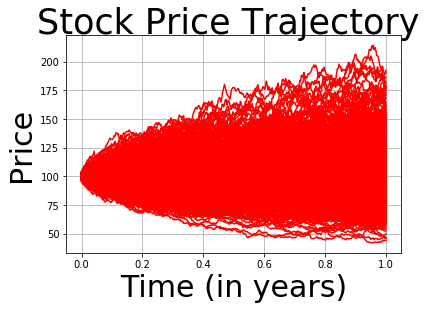

In [6]:
################################################
# (iii): Use Monte Carlo with control variates #
# and the Geometric Asian option as control    #
################################################
#-----------------------------------------------
M = 1000                               #simulations
price_trajectories    = []             #MC control variate array
payoff_array          = []
Arithmetic_Mean_array = []
discount_factor       = exp(-r * T)

# Tic
t = time.time()

# Calculating payoff vector.
for i in range(0, M):
    stock_path   = []

    S_j = S
    for i in range(0, N):
        xi = np.random.normal(0,1.0)

        S_j *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))

        stock_path.append(S_j)
    
    price_trajectories.append(stock_path)
    Arithmetic_Mean=np.sum(stock_path)/N
    payoff=max(Arithmetic_Mean-K,0)
    payoff_array.append(payoff)
    Arithmetic_Mean_array.append(Arithmetic_Mean)


# Variance Estimator & Covariance Estimator
Arithmetic_Mean_array = np.array(Arithmetic_Mean_array, dtype=float)
m=np.average(Arithmetic_Mean_array)
n=np.average(payoff_array)
varest  =sum((Arithmetic_Mean_array-m)**2)/(M-1)
covarest=sum(np.multiply(Arithmetic_Mean_array-m, payoff_array-n))/(M-1)

l = covarest / varest
#print(Arithmetic_Mean_array,payoff_array-n,covarest,varest,l)

# Computing price
PCV=exp(-r*T)*(1/M)*sum(payoff_array-l*Arithmetic_Mean_array)+l*S
print(str("Call Price: %.4f") % PCV)
             
# Statistics
varestCV=1/(M-1)*(PCV-exp(-r*T)*Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt)+l*S)**2;
RMSE=sqrt(varest)/sqrt(M)
# 95% C.I. uses 1.96 z-value
CI = [PCV-1.96*sqrt(varestCV)/sqrt(M),
      PCV+1.96*sqrt(varestCV)/sqrt(M)]

# Toc
elapsed = time.time() - t

#Print
print("95% Confidence Interval:", CI) 
print("Variance Estimator: %.4f" % varest)
print("RMSE: %.4f" % RMSE)
print("Run time: %.4f" % elapsed)

# Plot
price_trajectories = np.array(price_trajectories, dtype=float)
times = np.linspace(0, T, N)
plt.figure()
ax1 = plt.subplot2grid((1,1),(0,0))
for sublist in price_trajectories:
    ax1.plot(times,sublist,color = 'red')
ax1.grid(True)
plt.suptitle('Stock Price Trajectory', fontsize=35)
plt.xlabel('Time (in years)', fontsize = 30)
plt.ylabel('Price', fontsize= 30)
plt.show()

In [7]:
################################################
# Plot the root mean square error and the      #
# computational time as functions of the       #
# number of simulations M and compare          #
# with the theoretical convergence rate.       #
################################################
#-----------------------------------------------
################################################
# Preliminary function definitons.             #
################################################
# Practically, copying the code from the cases #
# above (MC, MC_AV, MC_CV) and defining        #
# functions with the suitable return values    #
# (RMSE & Run Time)                            #
################################################

def Arithmetic_Asian_MC_Run_Time(M,N):
    S = 100                             #spot price
    v = 0.25                            #volatility
    r = 0.02                            #interest rate
    T = 1                               #maturity
    K = 100                             #strike price
    delta_t= T / N                      #length of partition interval

    price_trajectories = []             #(plain) MC array
    payoff_array       = []
    discount_factor    = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, M):
        stock_path   = []

        S_j = S
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))

            stock_path.append(S_j)

        price_trajectories.append(stock_path)
        Arithmetic_Mean=np.sum(stock_path)/N
        payoff=max(Arithmetic_Mean-K,0)
        payoff_array.append(payoff)

    # Computing price
    payoff_array = np.array(payoff_array, dtype=float) 
    price = np.sum(discount_factor*payoff_array)/M

    # Statistics
    variance = np.var(discount_factor*payoff_array)
    sd = np.std(discount_factor*payoff_array)
    # Variance Estimator
    varest=sum((price-discount_factor*payoff_array)**2)/(M-1)
    # Root Mean Square Error
    RMSE=sqrt(varest)/sqrt(M)
    # 95% C.I. uses 1.96 z-value
    CI = [price - (1.96*sd/sqrt(float(M))),
          price + (1.96*sd/sqrt(float(M)))]

    # Toc
    elapsed = time.time() - t
    return elapsed

def Arithmetic_Asian_MC_RMSE(M,N):
    S = 100                             #spot price
    v = 0.25                            #volatility
    r = 0.02                            #interest rate
    T = 1                               #maturity
    K = 100                             #strike price
    delta_t= T / N                      #length of partition interval

    price_trajectories = []             #(plain) MC array
    payoff_array       = []
    discount_factor    = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, M):
        stock_path   = []

        S_j = S
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))

            stock_path.append(S_j)

        price_trajectories.append(stock_path)
        Arithmetic_Mean=np.sum(stock_path)/N
        payoff=max(Arithmetic_Mean-K,0)
        payoff_array.append(payoff)

    # Computing price
    payoff_array = np.array(payoff_array, dtype=float) 
    price = np.sum(discount_factor*payoff_array)/M

    # Statistics
    variance = np.var(discount_factor*payoff_array)
    sd = np.std(discount_factor*payoff_array)
    # Variance Estimator
    varest=sum((price-discount_factor*payoff_array)**2)/(M-1)
    # Root Mean Square Error
    RMSE=sqrt(varest)/sqrt(M)
    # 95% C.I. uses 1.96 z-value
    CI = [price - (1.96*sd/sqrt(float(M))),
          price + (1.96*sd/sqrt(float(M)))]

    # Toc
    elapsed = time.time() - t
    return RMSE

def Arithmetic_Asian_MC_AV_Run_Time(M,N):
    S = 100                             #spot price
    v = 0.25                            #volatility
    r = 0.02                            #interest rate
    T = 1                               #maturity
    K = 100                             #strike price
    delta_t= T / N                      #length of partition interval
    
    price_trajectories   = []           #(Antithetic Variates) MC array
    price_trajectories_a = []
    payoff_array         = []
    payoff_array_a       = []
    c                    = []           #Array for discounted payoffs
    discount_factor      = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, int(M/2)):
        stock_path     = []
        stock_path_a   = []             #array for storing antithetic variate paths

        S_j  =  S
        Sa_j =  S 
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j  *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))
            # Sa_j stands for Santithetic_j.
            Sa_j *= (exp((r-v**2/2) * delta_t - v *sqrt(delta_t) * xi))

            stock_path.append(S_j)
            stock_path_a.append(Sa_j)

        price_trajectories.append(stock_path)
        price_trajectories_a.append(stock_path_a)

        Arithmetic_Mean  =np.sum(stock_path  )/N
        Arithmetic_Mean_a=np.sum(stock_path_a)/N

        payoff  =max(Arithmetic_Mean  -K,0)
        payoff_a=max(Arithmetic_Mean_a-K,0)

        payoff_array.append(payoff)
        payoff_array_a.append(payoff_a)

    # Computing price
    payoff_array   = np.array(payoff_array  , dtype=float) 
    payoff_array_a = np.array(payoff_array_a, dtype=float) 
    c=(discount_factor*payoff_array+discount_factor*payoff_array_a)/2

    price = (np.sum(c))/(M/2)

    # Variance Estimator
    varest=sum((price-discount_factor*payoff_array)**2)/(M/2-1)
    # Root Mean Square Error
    RMSE=sqrt(varest)/sqrt(M/2)
    # 95% C.I. uses 1.96 z-value
    CI = [price - (1.96*RMSE),
          price + (1.96*RMSE)]

    # Toc
    elapsed = time.time() - t
    return elapsed

def Arithmetic_Asian_MC_AV_RMSE(M,N):
    S = 100                             #spot price
    v = 0.25                            #volatility
    r = 0.02                            #interest rate
    T = 1                               #maturity
    K = 100                             #strike price
    delta_t= T / N                      #length of partition interval
    
    price_trajectories   = []           #(Antithetic Variates) MC array
    price_trajectories_a = []
    payoff_array         = []
    payoff_array_a       = []
    c                    = []           #Array for discounted payoffs
    discount_factor      = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, int(M/2)):
        stock_path     = []
        stock_path_a   = []             #array for storing antithetic variate paths

        S_j  =  S
        Sa_j =  S 
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j  *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))
            # Sa_j stands for Santithetic_j.
            Sa_j *= (exp((r-v**2/2) * delta_t - v *sqrt(delta_t) * xi))

            stock_path.append(S_j)
            stock_path_a.append(Sa_j)

        price_trajectories.append(stock_path)
        price_trajectories_a.append(stock_path_a)

        Arithmetic_Mean  =np.sum(stock_path  )/N
        Arithmetic_Mean_a=np.sum(stock_path_a)/N

        payoff  =max(Arithmetic_Mean  -K,0)
        payoff_a=max(Arithmetic_Mean_a-K,0)

        payoff_array.append(payoff)
        payoff_array_a.append(payoff_a)

    # Computing price
    payoff_array   = np.array(payoff_array  , dtype=float) 
    payoff_array_a = np.array(payoff_array_a, dtype=float) 
    c=(discount_factor*payoff_array+discount_factor*payoff_array_a)/2

    price = (np.sum(c))/(M/2)

    # Variance Estimator
    varest=sum((price-discount_factor*payoff_array)**2)/(M/2-1)
    # Root Mean Square Error
    RMSE=sqrt(varest)/sqrt(M/2)
    # 95% C.I. uses 1.96 z-value
    CI = [price - (1.96*RMSE),
          price + (1.96*RMSE)]

    # Toc
    elapsed = time.time() - t
    return RMSE

def Arithmetic_Asian_MC_CV_Run_Time(M,N):
    price_trajectories    = []             #MC control variate array
    payoff_array          = []
    Arithmetic_Mean_array = []
    discount_factor       = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, M):
        stock_path   = []

        S_j = S
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))

            stock_path.append(S_j)

        price_trajectories.append(stock_path)
        Arithmetic_Mean=np.sum(stock_path)/N
        payoff=max(Arithmetic_Mean-K,0)
        payoff_array.append(payoff)
        Arithmetic_Mean_array.append(Arithmetic_Mean)


    # Variance Estimator & Covariance Estimator
    Arithmetic_Mean_array = np.array(Arithmetic_Mean_array, dtype=float)
    m=np.average(Arithmetic_Mean_array)
    n=np.average(payoff_array)
    varest  =sum((Arithmetic_Mean_array-m)**2)/(M-1)
    covarest=sum(np.multiply(Arithmetic_Mean_array-m, payoff_array-n))/(M-1)

    l = covarest / varest

    # Computing price
    PCV=exp(-r*T)*(1/M)*sum(payoff_array-l*Arithmetic_Mean_array)+l*S

    # Statistics
    varestCV=1/(M-1)*(PCV-exp(-r*T)*Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt)+l*S)**2;
    RMSE=sqrt(varest)/sqrt(M)
    # 95% C.I. uses 1.96 z-value
    CI = [PCV-1.96*sqrt(varestCV)/sqrt(M),
          PCV+1.96*sqrt(varestCV)/sqrt(M)]

    # Toc
    elapsed = time.time() - t
    return elapsed

def Arithmetic_Asian_MC_CV_RMSE(M,N):
    price_trajectories    = []             #MC control variate array
    payoff_array          = []
    Arithmetic_Mean_array = []
    discount_factor       = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, M):
        stock_path   = []

        S_j = S
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))

            stock_path.append(S_j)

        price_trajectories.append(stock_path)
        Arithmetic_Mean=np.sum(stock_path)/N
        payoff=max(Arithmetic_Mean-K,0)
        payoff_array.append(payoff)
        Arithmetic_Mean_array.append(Arithmetic_Mean)


    # Variance Estimator & Covariance Estimator
    Arithmetic_Mean_array = np.array(Arithmetic_Mean_array, dtype=float)
    m=np.average(Arithmetic_Mean_array)
    n=np.average(payoff_array)
    varest  =sum((Arithmetic_Mean_array-m)**2)/(M-1)
    covarest=sum(np.multiply(Arithmetic_Mean_array-m, payoff_array-n))/(M-1)

    l = covarest / varest

    # Computing price
    PCV=exp(-r*T)*(1/M)*sum(payoff_array-l*Arithmetic_Mean_array)+l*S

    # Statistics
    varestCV=1/(M-1)*(PCV-exp(-r*T)*Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt)+l*S)**2;
    RMSE=sqrt(varest)/sqrt(M)
    # 95% C.I. uses 1.96 z-value
    CI = [PCV-1.96*sqrt(varestCV)/sqrt(M),
          PCV+1.96*sqrt(varestCV)/sqrt(M)]

    # Toc
    elapsed = time.time() - t
    return RMSE

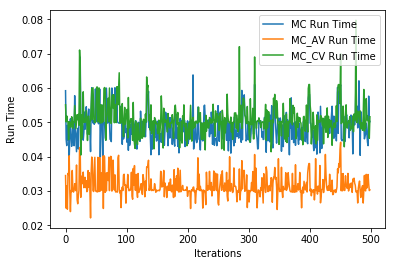

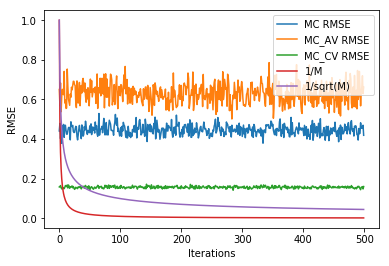

In [8]:
RMSE_MC       =[]
Run_Time_MC   =[]

RMSE_MC_AV    =[]
Run_Time_MC_AV=[]

RMSE_MC_CV    =[]
Run_Time_MC_CV=[]

N = 20                                 #number of discrete time points
M = 500                                #simulations

for i in range(0,M):
    Run_Time_MC.append(Arithmetic_Asian_MC_Run_Time(M,N))
    Run_Time_MC_AV.append(Arithmetic_Asian_MC_AV_Run_Time(M,N))
    Run_Time_MC_CV.append(Arithmetic_Asian_MC_CV_Run_Time(M,N))
    
    RMSE_MC.append(Arithmetic_Asian_MC_RMSE(M,N))
    RMSE_MC_AV.append(Arithmetic_Asian_MC_AV_RMSE(M,N))
    RMSE_MC_CV.append(Arithmetic_Asian_MC_CV_RMSE(M,N))
    
# Plotting Run_Time.
plt.plot(range(M),Run_Time_MC, label='MC Run Time')
plt.plot(range(M),Run_Time_MC_AV, label='MC_AV Run Time')      
plt.plot(range(M),Run_Time_MC_CV, label='MC_CV Run Time')       

plt.xlabel("Iterations")
plt.ylabel("Run Time")
plt.legend()
plt.show()
# Plotting RMSE.
plt.plot(range(M),RMSE_MC, label='MC RMSE')
plt.plot(range(M),RMSE_MC_AV, label='MC_AV RMSE')      
plt.plot(range(M),RMSE_MC_CV, label='MC_CV RMSE')
plt.plot(range(M),np.float_power(np.array(range(1,M+1)),-1), label='1/M')
plt.plot(range(M),np.float_power(np.array(range(1,M+1)),-1/2), label='1/sqrt(M)')

plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Call Price: 6.7590
95% Confidence Interval: [6.35676384074916, 6.6947702010999635]
Variance Estimator: 7.4349
Root Mean Square Error: 0.0862
Run time: 1.0552


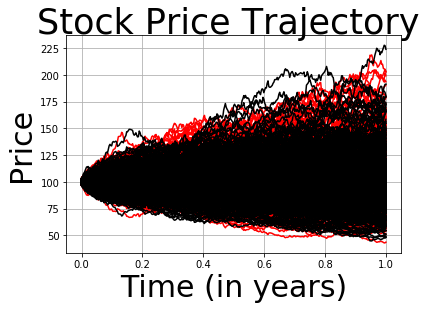

In [9]:
################################################
# Combine both variance reduction techniques.  #
################################################
#-----------------------------------------------
################################################
#                Hybrid Method                 #
################################################

M = 1000                               #simulations
N = 365                                #maturity
price_trajectories      = []           #(Antithetic Variates) MC array
price_trajectories_a    = []
payoff_array            = []
payoff_array_a          = []
Arithmetic_Mean_array   = []
Arithmetic_Mean_array_a = []
c                       = []           #Array for discounted payoffs
discount_factor         = exp(-r * T)

# Tic
t = time.time()

# Calculating payoff vector.
for i in range(0, int(M/2)):
    stock_path     = []
    stock_path_a   = []             #array for storing antithetic variate paths

    S_j  =  S
    Sa_j =  S 
    for i in range(0, N):
        xi = np.random.normal(0,1.0)

        S_j  *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))
        # Sa_j stands for Santithetic_j.
        Sa_j *= (exp((r-v**2/2) * delta_t - v *sqrt(delta_t) * xi))

        stock_path.append(S_j)
        stock_path_a.append(Sa_j)
    
    price_trajectories.append(stock_path)
    price_trajectories_a.append(stock_path_a)
    
    Arithmetic_Mean  =np.sum(stock_path  )/N
    Arithmetic_Mean_a=np.sum(stock_path_a)/N
    
    payoff  =max(Arithmetic_Mean  -K,0)
    payoff_a=max(Arithmetic_Mean_a-K,0)
    
    payoff_array.append(payoff)
    payoff_array_a.append(payoff_a)

    Arithmetic_Mean_array.append(Arithmetic_Mean)
    Arithmetic_Mean_array_a.append(Arithmetic_Mean_a)

# Variance Estimator & Covariance Estimator
Arithmetic_Mean_array   = np.array(Arithmetic_Mean_array,   dtype=float)
Arithmetic_Mean_array_a = np.array(Arithmetic_Mean_array_a, dtype=float)
m  =np.average(Arithmetic_Mean_array)
m_a=np.average(Arithmetic_Mean_array_a)
n  =np.average(payoff_array)
n_a=np.average(payoff_array_a)

varest  =sum((Arithmetic_Mean_array  -m  )**2)/(M/2-1)
varest_a=sum((Arithmetic_Mean_array_a-m_a)**2)/(M/2-1)

covarest  =sum(np.multiply(Arithmetic_Mean_array  -m  , payoff_array  -n  ))/(M/2-1)
covarest_a=sum(np.multiply(Arithmetic_Mean_array_a-m_a, payoff_array_a-n_a))/(M/2-1)

l   = covarest   / varest
l_a = covarest_a / varest_a

# Computing price
c  =exp(-r*T)*2/M*sum(payoff_array  -l  *Arithmetic_Mean_array  )+l  *S
c_a=exp(-r*T)*2/M*sum(payoff_array_a-l_a*Arithmetic_Mean_array_a)+l_a*S

price = (c+c_a)/2
print(str("Call Price: %.4f") % price)
             
# Statistics
Varest=1/(M/2-1)*(price-exp(-r*T)*Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt)+(l+l_a)/2*S)**2;
RMSE=sqrt(Varest)/sqrt(M)
# 95% C.I. uses 1.96 z-value
CI = [PCV-1.96*sqrt(Varest)/sqrt(M),
      PCV+1.96*sqrt(Varest)/sqrt(M)]

# Toc
elapsed = time.time() - t

#Print
print("95% Confidence Interval:", CI) 
print("Variance Estimator: %.4f" % Varest)
print("Root Mean Square Error: %.4f" % RMSE)
print("Run time: %.4f" % elapsed)

# Plot
price_trajectories   = np.array(price_trajectories  , dtype=float)
price_trajectories_a = np.array(price_trajectories_a, dtype=float)
times = np.linspace(0, T, N)
plt.figure()
ax1 = plt.subplot2grid((1,1),(0,0))
for sublist in price_trajectories:
    ax1.plot(times,sublist,color = 'red')
for sublist in price_trajectories_a:
    ax1.plot(times,sublist,color = 'black')
ax1.grid(True)
plt.suptitle('Stock Price Trajectory', fontsize=35)
plt.xlabel('Time (in years)', fontsize = 30)
plt.ylabel('Price', fontsize= 30)
plt.show()

In [10]:
################################################
# Repeating function definition for Hybrid     #
# method for Run Time and RMSE return.         #
################################################

def Arithmetic_Asian_MC_H_Run_Time(M,N):
    price_trajectories      = []           #(Antithetic Variates) MC array
    price_trajectories_a    = []
    payoff_array            = []
    payoff_array_a          = []
    Arithmetic_Mean_array   = []
    Arithmetic_Mean_array_a = []
    c                       = []           #Array for discounted payoffs
    discount_factor         = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, int(M/2)):
        stock_path     = []
        stock_path_a   = []             #array for storing antithetic variate paths

        S_j  =  S
        Sa_j =  S 
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j  *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))
            # Sa_j stands for Santithetic_j.
            Sa_j *= (exp((r-v**2/2) * delta_t - v *sqrt(delta_t) * xi))

            stock_path.append(S_j)
            stock_path_a.append(Sa_j)

        price_trajectories.append(stock_path)
        price_trajectories_a.append(stock_path_a)

        Arithmetic_Mean  =np.sum(stock_path  )/N
        Arithmetic_Mean_a=np.sum(stock_path_a)/N

        payoff  =max(Arithmetic_Mean  -K,0)
        payoff_a=max(Arithmetic_Mean_a-K,0)

        payoff_array.append(payoff)
        payoff_array_a.append(payoff_a)

        Arithmetic_Mean_array.append(Arithmetic_Mean)
        Arithmetic_Mean_array_a.append(Arithmetic_Mean_a)

    # Variance Estimator & Covariance Estimator
    Arithmetic_Mean_array   = np.array(Arithmetic_Mean_array,   dtype=float)
    Arithmetic_Mean_array_a = np.array(Arithmetic_Mean_array_a, dtype=float)
    m  =np.average(Arithmetic_Mean_array)
    m_a=np.average(Arithmetic_Mean_array_a)
    n  =np.average(payoff_array)
    n_a=np.average(payoff_array_a)

    varest  =sum((Arithmetic_Mean_array  -m  )**2)/(M/2-1)
    varest_a=sum((Arithmetic_Mean_array_a-m_a)**2)/(M/2-1)

    covarest  =sum(np.multiply(Arithmetic_Mean_array  -m  , payoff_array  -n  ))/(M/2-1)
    covarest_a=sum(np.multiply(Arithmetic_Mean_array_a-m_a, payoff_array_a-n_a))/(M/2-1)

    l   = covarest   / varest
    l_a = covarest_a / varest_a

    # Computing price
    c  =exp(-r*T)*2/M*sum(payoff_array  -l  *Arithmetic_Mean_array  )+l  *S
    c_a=exp(-r*T)*2/M*sum(payoff_array_a-l_a*Arithmetic_Mean_array_a)+l_a*S

    price = (c+c_a)/2
   
    # Statistics
    Varest=1/(M/2-1)*(price-exp(-r*T)*Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt)+(l+l_a)/2*S)**2;
    RMSE=sqrt(Varest)/sqrt(M)
    # 95% C.I. uses 1.96 z-value
    CI = [PCV-1.96*sqrt(Varest)/sqrt(M),
          PCV+1.96*sqrt(Varest)/sqrt(M)]

    # Toc
    elapsed = time.time() - t
    return elapsed

def Arithmetic_Asian_MC_H_RMSE(M,N):
    price_trajectories      = []           #(Antithetic Variates) MC array
    price_trajectories_a    = []
    payoff_array            = []
    payoff_array_a          = []
    Arithmetic_Mean_array   = []
    Arithmetic_Mean_array_a = []
    c                       = []           #Array for discounted payoffs
    discount_factor         = exp(-r * T)

    # Tic
    t = time.time()

    # Calculating payoff vector.
    for i in range(0, int(M/2)):
        stock_path     = []
        stock_path_a   = []             #array for storing antithetic variate paths

        S_j  =  S
        Sa_j =  S 
        for i in range(0, N):
            xi = np.random.normal(0,1.0)

            S_j  *= (exp((r-v**2/2) * delta_t + v *sqrt(delta_t) * xi))
            # Sa_j stands for Santithetic_j.
            Sa_j *= (exp((r-v**2/2) * delta_t - v *sqrt(delta_t) * xi))

            stock_path.append(S_j)
            stock_path_a.append(Sa_j)

        price_trajectories.append(stock_path)
        price_trajectories_a.append(stock_path_a)

        Arithmetic_Mean  =np.sum(stock_path  )/N
        Arithmetic_Mean_a=np.sum(stock_path_a)/N

        payoff  =max(Arithmetic_Mean  -K,0)
        payoff_a=max(Arithmetic_Mean_a-K,0)

        payoff_array.append(payoff)
        payoff_array_a.append(payoff_a)

        Arithmetic_Mean_array.append(Arithmetic_Mean)
        Arithmetic_Mean_array_a.append(Arithmetic_Mean_a)

    # Variance Estimator & Covariance Estimator
    Arithmetic_Mean_array   = np.array(Arithmetic_Mean_array,   dtype=float)
    Arithmetic_Mean_array_a = np.array(Arithmetic_Mean_array_a, dtype=float)
    m  =np.average(Arithmetic_Mean_array)
    m_a=np.average(Arithmetic_Mean_array_a)
    n  =np.average(payoff_array)
    n_a=np.average(payoff_array_a)

    varest  =sum((Arithmetic_Mean_array  -m  )**2)/(M/2-1)
    varest_a=sum((Arithmetic_Mean_array_a-m_a)**2)/(M/2-1)

    covarest  =sum(np.multiply(Arithmetic_Mean_array  -m  , payoff_array  -n  ))/(M/2-1)
    covarest_a=sum(np.multiply(Arithmetic_Mean_array_a-m_a, payoff_array_a-n_a))/(M/2-1)

    l   = covarest   / varest
    l_a = covarest_a / varest_a

    # Computing price
    c  =exp(-r*T)*2/M*sum(payoff_array  -l  *Arithmetic_Mean_array  )+l  *S
    c_a=exp(-r*T)*2/M*sum(payoff_array_a-l_a*Arithmetic_Mean_array_a)+l_a*S

    price = (c+c_a)/2

    # Statistics
    Varest=1/(M/2-1)*(price-exp(-r*T)*Geometric_Asian_Option_price(S0,sigma,K,r,T,Nt)+(l+l_a)/2*S)**2;
    RMSE=sqrt(Varest)/sqrt(M)
    # 95% C.I. uses 1.96 z-value
    CI = [PCV-1.96*sqrt(Varest)/sqrt(M),
          PCV+1.96*sqrt(Varest)/sqrt(M)]

    # Toc
    elapsed = time.time() - t
    return RMSE

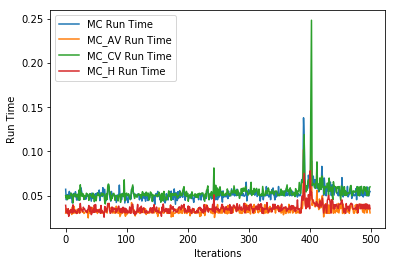

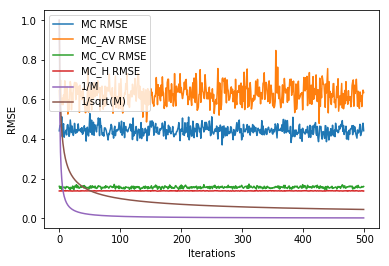

In [11]:
################################################
# Plotting Run Time & RMSE for all methods     #
################################################

RMSE_MC       =[]
Run_Time_MC   =[]

RMSE_MC_AV    =[]
Run_Time_MC_AV=[]

RMSE_MC_CV    =[]
Run_Time_MC_CV=[]

RMSE_MC_H     =[]
Run_Time_MC_H =[]

N = 20                                 #number of discrete time points
M = 500                                #simulations

for i in range(0,M):
    Run_Time_MC.append(Arithmetic_Asian_MC_Run_Time(M,N))
    Run_Time_MC_AV.append(Arithmetic_Asian_MC_AV_Run_Time(M,N))
    Run_Time_MC_CV.append(Arithmetic_Asian_MC_CV_Run_Time(M,N))
    Run_Time_MC_H.append(Arithmetic_Asian_MC_H_Run_Time(M,N))
    
    RMSE_MC.append(Arithmetic_Asian_MC_RMSE(M,N))
    RMSE_MC_AV.append(Arithmetic_Asian_MC_AV_RMSE(M,N))
    RMSE_MC_CV.append(Arithmetic_Asian_MC_CV_RMSE(M,N))
    RMSE_MC_H.append(Arithmetic_Asian_MC_H_RMSE(M,N))
    
# Plotting Run_Time.
plt.plot(range(M),Run_Time_MC, label='MC Run Time')
plt.plot(range(M),Run_Time_MC_AV, label='MC_AV Run Time')      
plt.plot(range(M),Run_Time_MC_CV, label='MC_CV Run Time')   
plt.plot(range(M),Run_Time_MC_H, label='MC_H Run Time')    

plt.xlabel("Iterations")
plt.ylabel("Run Time")
plt.legend()
plt.show()
# Plotting RMSE.
plt.plot(range(M),RMSE_MC, label='MC RMSE')
plt.plot(range(M),RMSE_MC_AV, label='MC_AV RMSE')      
plt.plot(range(M),RMSE_MC_CV, label='MC_CV RMSE')
plt.plot(range(M),RMSE_MC_H, label='MC_H RMSE')
plt.plot(range(M),np.float_power(np.array(range(1,M+1)),-1), label='1/M')
plt.plot(range(M),np.float_power(np.array(range(1,M+1)),-1/2), label='1/sqrt(M)')

plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()